# Imports

In [15]:
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows

from numpy import multiply

from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

# Loading data

In [2]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

In [3]:
# Dataset raw -- sem corte em freq, sem janelamento
dataset.datasets[0].raw.to_data_frame()

,time,Fz,FC3,FC1,FCz,FC2,FC4,C5,C3,C1,...,CP2,CP4,P1,Pz,P2,POz,EOG1,EOG2,EOG3,stim
0,0.000,6.494141,-0.146484,4.736328,3.857422,2.148437,-2.587891,-1.660156,-1.464844,0.488281,...,-6.884766,-7.910156,-14.062500,-9.423828,-13.525391,-18.066406,-3.417969,8.300781,5.859375,0.0
1,0.004,3.906250,-2.832031,1.269531,0.341797,-1.855469,-6.396484,-5.810547,-5.419922,-1.171875,...,-11.718750,-13.378906,-16.699219,-13.281250,-19.335937,-23.095703,2.441406,10.253906,0.976562,0.0
2,0.008,9.912109,6.738281,7.226562,7.666016,3.955078,2.490234,0.976562,3.515625,5.371094,...,-4.003906,-4.394531,-8.837891,-4.980469,-10.742188,-13.867187,9.277344,13.671875,6.347656,0.0
3,0.012,7.421875,4.003906,4.638672,6.591797,1.025391,3.564453,2.685547,6.005859,4.541016,...,-4.931641,-6.152344,-8.251953,-7.226562,-13.623047,-17.675781,10.742188,13.183594,5.859375,0.0
4,0.016,-5.712891,-4.687500,-5.566406,-4.638672,-9.472656,-8.105469,-5.810547,-2.343750,-3.369141,...,-13.525391,-15.380859,-14.013672,-14.013672,-21.191406,-23.339844,-5.371094,0.000000,-6.347656,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96730,386.920,-18.261719,-8.789062,-11.669922,-13.525391,-17.480469,-20.947266,-7.177734,-6.933594,-9.375000,...,-23.876953,-28.955078,-11.425781,-18.798828,-20.068359,-14.160156,-1.953125,-46.386719,-12.207031,0.0
96731,386.924,-8.056641,4.589844,1.562500,-3.759766,-5.419922,-10.986328,5.126953,4.003906,2.099609,...,-14.501953,-19.970703,-2.880859,-10.009766,-11.083984,-4.882812,0.976562,-45.898438,-12.207031,0.0
96732,386.928,-14.160156,5.419922,-3.173828,-4.394531,-10.156250,-12.353516,-0.292969,3.271484,-3.417969,...,-16.748047,-22.851562,-5.957031,-12.207031,-13.232422,-7.373047,-1.464844,-50.781250,-10.742188,0.0
96733,386.932,-24.707031,-12.402344,-15.869141,-19.970703,-22.265625,-30.810547,-13.037109,-14.355469,-15.673828,...,-27.832031,-33.056641,-16.503906,-23.193359,-23.095703,-15.771484,-10.253906,-56.152344,-20.507812,0.0


# Preprocess

In [4]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size),
    Preprocessor('resample', sfreq=100)
    
]

# Transform the data
preprocess(dataset, preprocessors)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



/home/barbon/.virtualenvs/ia376/lib/python3.11/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Splitting

We can easily split ds based on a criteria applied to the description
DataFrame:



In [5]:
subsets = dataset.split("session")
print({subset_name: len(subset) for subset_name, subset in subsets.items()})

{'session_E': 232164, 'session_T': 232164}


Next, we use a windower to extract events from the dataset based on events:

In [9]:
channels = []


def get_windows_dataset(dataset, channels):

    # Configuration
    trial_start_offset_samples=0
    trial_stop_offset_samples=100
    window_size_samples=400 # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
    window_stride_samples=100
    drop_last_window=False
    verbose = None

    if len(channels) != 0:
        windows_dataset = create_windows_from_events(
        concat_ds = dataset, 
        trial_start_offset_samples = trial_start_offset_samples, 
        trial_stop_offset_samples = trial_stop_offset_samples,
        window_size_samples = window_size_samples, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
        window_stride_samples = window_stride_samples,
        drop_last_window=drop_last_window,
        picks = channels,
        verbose = verbose
        )
    else:
        windows_dataset = create_windows_from_events(
        concat_ds = dataset, 
        trial_start_offset_samples = trial_start_offset_samples, 
        trial_stop_offset_samples = trial_stop_offset_samples,
        window_size_samples = window_size_samples, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
        window_stride_samples = window_stride_samples,
        drop_last_window=drop_last_window,
        verbose=verbose
)

    return windows_dataset

windows_dataset = get_windows_dataset(dataset, channels = channels)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 400 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
96 matching events 

In [8]:
# windows_dataset = create_windows_from_events(
#     dataset, 
#     trial_start_offset_samples=0, 
#     trial_stop_offset_samples=100,
#     window_size_samples=400, # Numero de samples em uma janela. Como sfreq=100, definido anteriormente, janela será de 4s
#     window_stride_samples=100,
#     drop_last_window=False,
#     picks = channels)

We can iterate through the windows_ds which yields a window x,
a target y, and window_ind (which itself contains ``i_window_in_trial``,
``i_start_in_trial``, and ``i_stop_in_trial``, which are required for
combining window predictions in the scorer).



In [10]:
windows_dataset.datasets[0].windows.to_data_frame()

Using data from preloaded Raw for 96 events and 400 original time points ...


,time,condition,epoch,Fz,FC3,FC1,FCz,FC2,FC4,C5,...,C6,CP3,CP1,CPz,CP2,CP4,P1,Pz,P2,POz
0,0.00,left_hand,0,3.153433e+05,-4.428506e+05,-3.310279e+05,-3.045484e+05,5.060538e+03,1.745914e+05,-9.131285e+05,...,1.376825e+06,-8.967052e+05,-8.514950e+04,2.704514e+05,5.600709e+05,9.037199e+05,334661.075889,741330.794769,795616.958813,5.938728e+05
1,0.01,left_hand,0,-1.056485e+06,-1.891338e+06,-2.001724e+06,-1.547252e+06,-1.515183e+06,-9.597070e+05,-2.368881e+06,...,-6.510242e+05,-1.516998e+06,-1.455446e+06,-8.356352e+05,-9.004758e+05,-7.755920e+05,-418043.320079,-286176.240550,-416805.334965,-2.723183e+04
2,0.02,left_hand,0,-1.732582e+06,-2.517024e+06,-2.255060e+06,-2.056816e+06,-1.666803e+06,-1.650148e+06,-2.235122e+06,...,-1.765142e+06,-1.353226e+06,-1.147762e+06,-1.144640e+06,-1.267094e+06,-1.430391e+06,-405593.978302,-556795.334363,-863073.386290,-1.078296e+05
3,0.03,left_hand,0,-9.593655e+05,-1.428228e+06,-1.056294e+06,-1.074024e+06,-6.596459e+05,-5.663761e+05,-9.314411e+05,...,-4.551714e+05,-1.966069e+05,-8.729995e+04,-8.118692e+04,-1.374359e+05,-1.521208e+05,191855.623313,52938.674683,-208242.004079,2.233955e+05
4,0.04,left_hand,0,-7.572313e+05,-5.219912e+05,-4.793461e+05,-7.858793e+05,-6.006970e+05,-2.666928e+05,2.390867e+05,...,4.192805e+05,3.621720e+05,-1.338298e+05,-3.071664e+05,-4.069307e+05,-2.332164e+05,3493.451875,-245760.714416,-376135.486461,1.987829e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,3.95,tongue,95,8.933504e+05,2.170489e+05,7.119303e+05,1.086621e+06,1.209018e+06,8.983233e+05,4.364560e+05,...,1.067344e+06,4.704084e+05,6.655892e+05,5.467124e+05,5.462929e+05,5.888476e+05,841452.023481,632765.136923,436921.723308,1.028191e+06
38396,3.96,tongue,95,3.315730e+04,-1.075975e+05,-3.047643e+04,2.229959e+05,3.642753e+04,-3.002328e+05,1.615488e+04,...,-3.712260e+05,-4.474465e+05,-5.886059e+05,-6.755687e+05,-8.624148e+05,-9.149623e+05,-714655.093890,-875460.958865,-965005.457519,-5.428110e+05
38397,3.97,tongue,95,5.734750e+05,1.149425e+06,6.061839e+05,6.065376e+05,2.866689e+05,3.265404e+05,4.058434e+05,...,-6.775881e+05,5.449122e+04,-4.051041e+05,-5.483233e+05,-7.764994e+05,-9.137147e+05,-420354.546130,-564159.971967,-676037.475866,-2.466904e+05
38398,3.98,tongue,95,1.390031e+06,1.359554e+06,1.204547e+06,1.045177e+06,8.603767e+05,6.710455e+05,1.235027e+06,...,4.080763e+05,7.657514e+05,4.684163e+05,2.659643e+05,-4.765346e+03,-1.317523e+05,276075.942697,186851.671168,59967.573950,1.666854e+04


We visually inspect the windows:


Using data from preloaded Raw for 1 events and 400 original time points ...
Using data from preloaded Raw for 1 events and 400 original time points ...
Using data from preloaded Raw for 1 events and 400 original time points ...


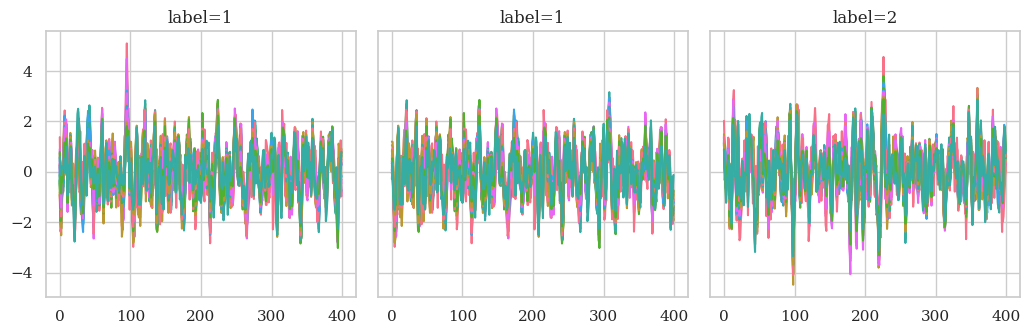

In [13]:
max_i = 2
fig, ax_arr = plt.subplots(1, max_i + 1, figsize=(3.5 * (max_i + 1), 3.5),
                           sharex=True, sharey=True)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    ax_arr[i].plot(x.T)
    # ax_arr[i].set_ylim(-4e-5, 4e-5)
    ax_arr[i].set_title(f"label={y}")
    if i == max_i:
        break

fig.tight_layout()

Alternatively, we can create evenly spaced ("sliding") windows using a
different windower.



In [16]:
sliding_windows_dataset = create_fixed_length_windows(
    dataset, start_offset_samples=0, stop_offset_samples=0,
    window_size_samples=1200, window_stride_samples=1000,
    drop_last_window=False)

print(len(sliding_windows_dataset))
for x, y, window_ind in sliding_windows_dataset:
    print(x.shape, y, window_ind)
    break

sliding_windows_dataset.description

Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 39 events and 1200 original time points ...
0 bad epochs dropped
Using data

/home/barbon/.virtualenvs/ia376/lib/python3.11/site-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3
4,3,session_T,run_4
5,3,session_T,run_5
6,3,session_E,run_0
7,3,session_E,run_1
8,3,session_E,run_2
9,3,session_E,run_3


Plotting channels from a single window:

Using data from preloaded Raw for 1 events and 400 original time points ...


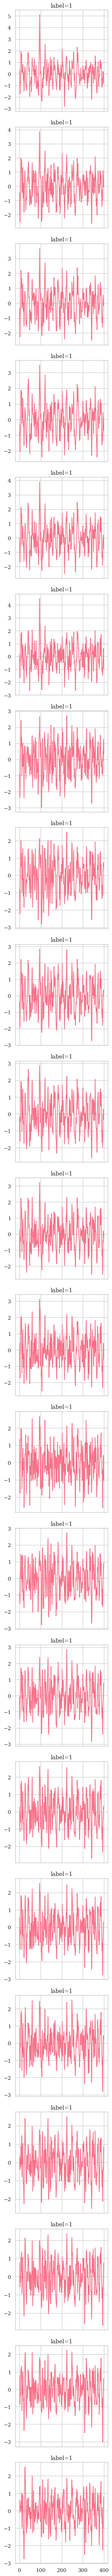

In [18]:
n_channels = 22
fig, ax_arr = plt.subplots(n_channels, 1, figsize=(3.5, n_channels * 3.5),
                           sharex=True, sharey=False)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    for n in range(n_channels):
      ax_arr[n].plot(x[n,:].T)
      # ax_arr[n].set_ylim(-4e-5, 4e-5)
      ax_arr[n].set_title(f"label={y}")
    break

fig.tight_layout()

Transforms can also be applied on windows in the same way as shown
above on continuous data:



['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'] 300
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE:

/tmp/ipykernel_459484/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_459484/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_459484/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_459484/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (3.99 s)
  windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
/tmp/ipykernel_459484/3320255694.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.E

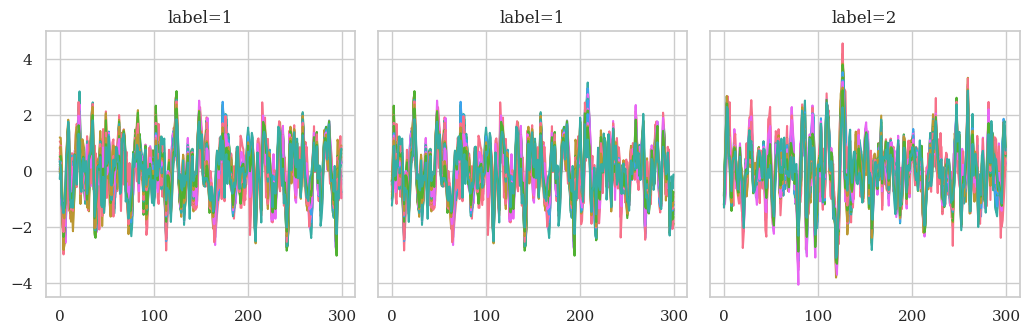

In [20]:
def crop_windows(windows, start_offset_samples, stop_offset_samples):
    fs = windows.info["sfreq"]
    windows.crop(tmin=start_offset_samples / fs, tmax=stop_offset_samples / fs,
                 include_tmax=False)


epochs_preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(crop_windows, apply_on_array=False, start_offset_samples=100,
                 stop_offset_samples=900)
]

print(windows_dataset.datasets[0].windows.info["ch_names"],
      len(windows_dataset.datasets[0].windows.times))
preprocess(windows_dataset, epochs_preprocessors)
print(windows_dataset.datasets[0].windows.info["ch_names"],
      len(windows_dataset.datasets[0].windows.times))


max_i = 2
fig, ax_arr = plt.subplots(1, max_i + 1, figsize=(3.5 * (max_i + 1), 3.5),
                           sharex=True, sharey=True)
for i, (x, y, window_ind) in enumerate(windows_dataset):
    ax_arr[i].plot(x.T)
    # ax_arr[i].set_ylim(-4e-5, 4e-5)
    ax_arr[i].set_title(f"label={y}")
    if i == max_i:
        break

fig.tight_layout()
plt.show()